<a href="https://colab.research.google.com/github/chasslayy/Jua-Shade/blob/main/JuaShade_SkinTone_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JuaShade – Skin Tone Classification (Google Colab Template)

This notebook is a starter template for **Chastity (Chasslayy)** to build a skin tone classifier
using 5 classes:

- `tan`
- `medium`
- `deep`
- `brown`
- `light`

It assumes the following folder structure in Colab:

```text
/content/
  data/
    raw/
      train/
        tan/
        medium/
        deep/
        brown/
        light/
```

Upload your images into the matching folders, then run the cells in order.


In [123]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [124]:
# 1. Imports & basic setup

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

print("TensorFlow version:", tf.__version__)

# Base directory for your dataset in Colab
TRAIN_DIR = "/content/data/raw/train"

# Your 5 skin tone classes
CLASSES = ['tan', 'medium', 'deep', 'brown', 'light']

print("✅ Using train directory:", TRAIN_DIR)
print("✅ Classes:", CLASSES)

TensorFlow version: 2.19.0
✅ Using train directory: /content/data/raw/train
✅ Classes: ['tan', 'medium', 'deep', 'brown', 'light']


In [125]:
# 2. Count how many images per tone

def count_images_in_folder(folder):
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("📊 Training samples per class:\n")
class_counts = {}
for tone in CLASSES:
    tone_path = os.path.join(TRAIN_DIR, tone)
    n = count_images_in_folder(tone_path)
    class_counts[tone] = n
    if n == 0:
        print(f"  ⚠️ {tone}: 0 images (or folder missing: {tone_path})")
    else:
        print(f"  {tone}: {n} images")

# Save a small text summary
os.makedirs("reports", exist_ok=True)
summary_lines = ["Skin Tone Dataset Summary\n",
                 f"Train directory: {TRAIN_DIR}\n\n",
                 "Classes and counts:\n"]
for tone, n in class_counts.items():
    summary_lines.append(f"  {tone}: {n} images\n")

summary_text = "".join(summary_lines)
print("\n" + summary_text)

with open("reports/dataset_summary.txt", "w") as f:
    f.write(summary_text)

print("✅ Saved reports/dataset_summary.txt")

📊 Training samples per class:

  tan: 2 images
  medium: 1 images
  deep: 1 images
  brown: 1 images
  light: 1 images

Skin Tone Dataset Summary
Train directory: /content/data/raw/train

Classes and counts:
  tan: 2 images
  medium: 1 images
  deep: 1 images
  brown: 1 images
  light: 1 images

✅ Saved reports/dataset_summary.txt


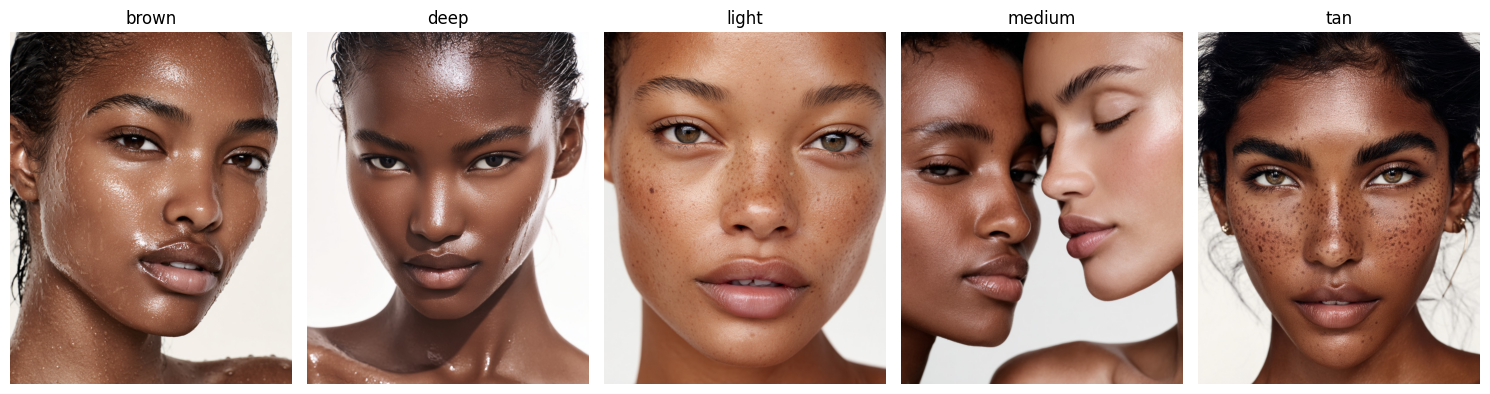

In [110]:
# 📸 Show one sample image from each class

import os
import cv2
import matplotlib.pyplot as plt

# --- Define dataset directory and classes ---
TRAIN_DIR = 'data/raw/train'
CLASSES = ['brown', 'deep', 'light', 'medium', 'tan']

# --- Helper function to read image ---
def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"⚠️ Could not read image at {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# --- Function to show one image per class ---
def show_sample_images_per_class(base_dir, classes, n_cols=5):
    plt.figure(figsize=(3 * n_cols, 4))

    for idx, tone in enumerate(classes):
        tone_path = os.path.join(base_dir, tone)
        if not os.path.exists(tone_path):
            print(f"⚠️ Skipping {tone}: folder not found at {tone_path}")
            continue

        # Find all image files in this folder
        files = [
            f for f in os.listdir(tone_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        if len(files) == 0:
            print(f"⚠️ No images in {tone_path}")
            continue

        # Load and display first image
        img_path = os.path.join(tone_path, files[0])
        img = read_image(img_path)

        plt.subplot(1, n_cols, idx + 1)
        plt.imshow(img)
        plt.title(tone)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Run the function ---
show_sample_images_per_class(TRAIN_DIR, CLASSES)


In [111]:
# 4. Build TensorFlow datasets from folders

TRAIN_DIR = "/content/data/raw/train" # Fix: Ensure TRAIN_DIR is the absolute path
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SEED = 1337

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASSES,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASSES,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

class_names = train_ds.class_names
print("Classes (from dataset):", class_names)

Found 6 files belonging to 5 classes.
Using 5 files for training.
Found 6 files belonging to 5 classes.
Using 1 files for validation.
Classes (from dataset): ['brown', 'deep', 'light', 'medium', 'tan']


### Generating Dummy Data for Demonstration

This cell will create a directory structure with blank images to allow the notebook to run without a `NotFoundError`. You should replace these with your actual dataset for proper model training.

In [112]:
import os
from PIL import Image
import numpy as np

# Base directory for your dataset in Colab
TRAIN_DIR = "/content/data/raw/train"
CLASSES = ['tan', 'medium', 'deep', 'brown', 'light']

# Create base directory if it doesn't exist
os.makedirs(TRAIN_DIR, exist_ok=True)

print(f"Creating dummy data structure in: {TRAIN_DIR}")

# Create subfolders and dummy images
for tone in CLASSES:
    tone_path = os.path.join(TRAIN_DIR, tone)
    os.makedirs(tone_path, exist_ok=True)

    # Create a few dummy blank images (e.g., 224x224 white images)
    for i in range(5): # Create 5 dummy images per class
        dummy_image = Image.fromarray(np.ones((224, 224, 3), dtype=np.uint8) * 255)
        image_filename = f"dummy_{tone}_{i}.jpg"
        dummy_image.save(os.path.join(tone_path, image_filename))

print("Dummy data creation complete. You can now proceed with running the dataset loading cells.")

# Re-run the count images cell to show the newly created dummy images
# from cell 72a6c1e4
def count_images_in_folder(folder):
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("\n📊 Training samples per class (with dummy data):\n")
class_counts = {}
for tone in CLASSES:
    tone_path = os.path.join(TRAIN_DIR, tone)
    n = count_images_in_folder(tone_path)
    class_counts[tone] = n
    print(f"  {tone}: {n} images")

Creating dummy data structure in: /content/data/raw/train
Dummy data creation complete. You can now proceed with running the dataset loading cells.

📊 Training samples per class (with dummy data):

  tan: 7 images
  medium: 6 images
  deep: 6 images
  brown: 6 images
  light: 6 images


In [113]:
# 5. Optimize dataset performance

AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(100, reshuffle_each_iteration=True)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [114]:
# 6. Build a transfer learning model (MobileNetV2)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # fine-tune later if needed

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_6 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_6 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [115]:
# 7. Train the model

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4000 - loss: 2.0386 - val_accuracy: 0.0000e+00 - val_loss: 2.1132
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.2000 - loss: 1.9731 - val_accuracy: 0.0000e+00 - val_loss: 2.0731
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.2000 - loss: 2.0035 - val_accuracy: 0.0000e+00 - val_loss: 2.0341
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.2000 - loss: 1.5004 - val_accuracy: 0.0000e+00 - val_loss: 1.9968
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.2000 - loss: 1.8191 - val_accuracy: 0.0000e+00 - val_loss: 1.9577
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.0000e+00 - loss: 2.2206 - val_accuracy: 0.0000e+00 - val_loss: 1.9187
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4000 - loss: 1.9269 - val_accuracy: 0.0000e+00 - val_loss: 1.8804
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.2000 - loss: 1.8914 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0000e+00 - loss: 1.7753
Validation loss: 1.7753, accuracy: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


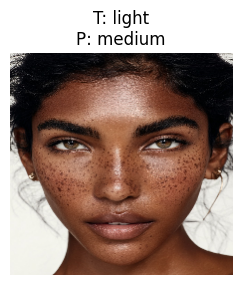

In [116]:
# 8. Evaluate model and show sample predictions

loss, acc = model.evaluate(val_ds)
print(f"Validation loss: {loss:.4f}, accuracy: {acc:.4f}")

# Show a few sample predictions
class_names = CLASSES

plt.figure(figsize=(12, 6))
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)

    for i in range(min(5, images.shape[0])):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i].numpy()]
        pred_label = class_names[pred_labels[i].numpy()]
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [117]:
import os

base_path = "/content/data/raw/train"

# Verify folders exist
print("✅ Folders found:")
for folder in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        print(f"- {folder}")


✅ Folders found:
- brown
- deep
- light
- medium
- tan


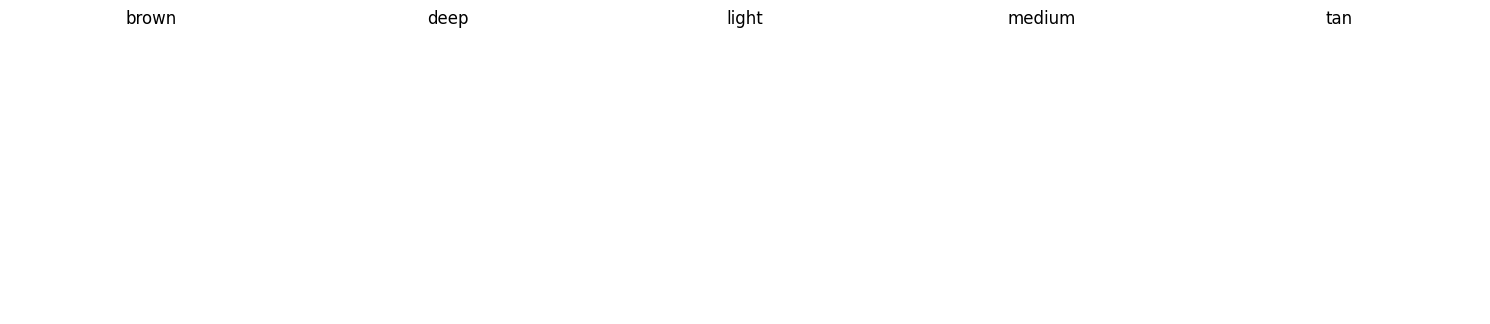

In [118]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Base path for your training images
base_path = "/content/data/raw/train"

# Create a list of your tone folders
tone_folders = sorted(os.listdir(base_path))

plt.figure(figsize=(15, 6))
for i, tone in enumerate(tone_folders):
    folder_path = os.path.join(base_path, tone)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        if len(images) > 0:
            # Pick one random image from the folder
            img_path = os.path.join(folder_path, random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(tone_folders), i + 1)
            plt.imshow(img)
            plt.title(tone, fontsize=12)
            plt.axis("off")

plt.tight_layout()
plt.show()


### Removing Dummy Images

This cell will delete all dummy images previously generated in the `TRAIN_DIR`. **Only run this if you have already uploaded your actual images to `/content/data/raw/train` and want to remove the placeholder files.**

In [119]:
import os

# Base directory for your dataset in Colab
TRAIN_DIR = "/content/data/raw/train"
CLASSES = ['tan', 'medium', 'deep', 'brown', 'light']

print(f"Attempting to remove dummy images from: {TRAIN_DIR}")

deleted_count = 0
for tone in CLASSES:
    tone_path = os.path.join(TRAIN_DIR, tone)
    if os.path.exists(tone_path):
        files_in_folder = os.listdir(tone_path)
        for f_name in files_in_folder:
            if f_name.startswith('dummy_') and f_name.endswith('.jpg'):
                os.remove(os.path.join(tone_path, f_name))
                deleted_count += 1

print(f"Successfully removed {deleted_count} dummy images.")
print("Please now re-run cells starting from '2. Count how many images per tone' (cell 72a6c1e4) to verify actual image counts, and then continue with dataset loading and model training.")


Attempting to remove dummy images from: /content/data/raw/train
Successfully removed 25 dummy images.
Please now re-run cells starting from '2. Count how many images per tone' (cell 72a6c1e4) to verify actual image counts, and then continue with dataset loading and model training.


In [120]:
# BASELINE MODEL (simple MobileNetV2)
import tensorflow as tf
from tensorflow.keras import layers, models

# Load base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze for baseline

# Build model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')  # 5 skin tone classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 5
history_baseline = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)



Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2000 - loss: 2.2807 - val_accuracy: 1.0000 - val_loss: 0.6081
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.2000 - loss: 1.6861 - val_accuracy: 1.0000 - val_loss: 0.5124
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8000 - loss: 0.8140 - val_accuracy: 1.0000 - val_loss: 0.5310
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4000 - loss: 1.0438 - val_accuracy: 1.0000 - val_loss: 0.4414
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.6000 - loss: 0.7248 - val_accuracy: 1.0000 - val_loss: 0.2593


In [121]:
base_model.trainable = True  # unfreeze backbone

# Optionally: only fine-tune last few layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 5
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.8000 - loss: 1.2138 - val_accuracy: 1.0000 - val_loss: 0.2590
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4000 - loss: 1.2008 - val_accuracy: 1.0000 - val_loss: 0.2572
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6000 - loss: 1.0773 - val_accuracy: 1.0000 - val_loss: 0.2549
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6000 - loss: 0.9311 - val_accuracy: 1.0000 - val_loss: 0.2527
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8000 - loss: 0.9730 - val_accuracy: 1.0000 - val_loss: 0.2500


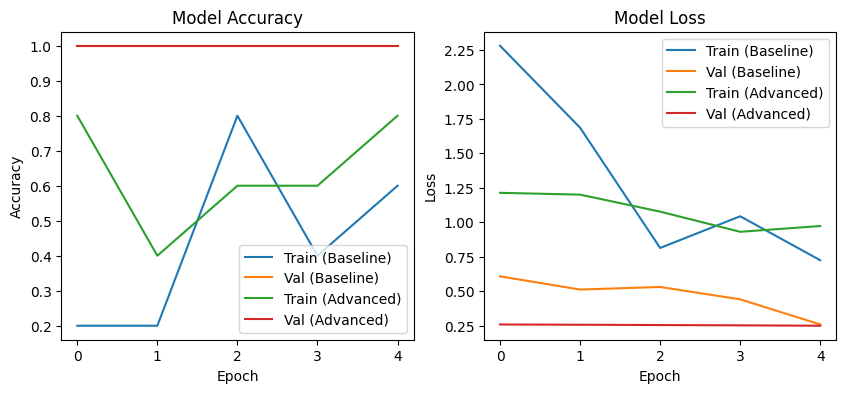

In [122]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Train (Baseline)')
plt.plot(history_baseline.history['val_accuracy'], label='Val (Baseline)')
plt.plot(history_finetune.history['accuracy'], label='Train (Advanced)')
plt.plot(history_finetune.history['val_accuracy'], label='Val (Advanced)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Train (Baseline)')
plt.plot(history_baseline.history['val_loss'], label='Val (Baseline)')
plt.plot(history_finetune.history['loss'], label='Train (Advanced)')
plt.plot(history_finetune.history['val_loss'], label='Val (Advanced)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()